# Social Reward Second Level Analyses

## Set Up

### Import packages

In [1]:
import os
import glob
import pandas as pd
import numpy as np

from matplotlib.gridspec import GridSpec

# Import cerebellum packages
import matplotlib.pyplot as plt
import SUITPy.flatmap as flatmap

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img, cluster_level_inference

import importlib

import helpful_functions
importlib.reload(helpful_functions)

<module 'helpful_functions' from '/data/neuron/SCN/SR/code/hpopal/helpful_functions.py'>

### Set directories and import subject data

In [2]:
#bids_dir = '/data/projects/social_doors/'
bids_dir = '/data/neuron/SCN/SR/'


os.chdir(bids_dir)

data_dir = os.path.join(bids_dir, 'derivatives','SR_univariate')
outp_dir = data_dir+'group/'

# Import scan info for runs that passed QC
subjs_scan_info = pd.read_csv(bids_dir+'/derivatives/participants_good.csv')

# Create a participant list for only those with good scans
subjs_list = list(subjs_scan_info['participant_id'].unique())
subjs_list.sort()

# Import other participant info like demographics
subjs_info = pd.read_csv(bids_dir+'participants.tsv', sep='\t', index_col=0)
#subjs_info = subjs_info.rename(columns={'participant_id': 'subject_label'})

# Filter for only participants with good scan data
subjs_info = subjs_info.loc[subjs_list]

# Rename group IDs
subjs_info['group'] = subjs_info['group'].map({1: 'not_asd', 2: 'asd'})

# Reset index to make participant IDs a column
subjs_info = subjs_info.reset_index()


subjs_info_typ = subjs_info[subjs_info['group']=='not_asd']
subjs_info_asd = subjs_info[subjs_info['group']=='asd']

#subjs_list = subjs_info.index.to_list()
subjs_list_typ = subjs_info_typ['participant_id'].to_list()
subjs_list_asd = subjs_info_asd['participant_id'].to_list()

print('Found '+str(len(subjs_list_typ))+' non-autistic participants')
print('Found '+str(len(subjs_list_asd))+' autistic participants')

Found 52 non-autistic participants
Found 21 autistic participants


# Non-Autistic Adolescents

<Axes: label='conditions', ylabel='scan number'>

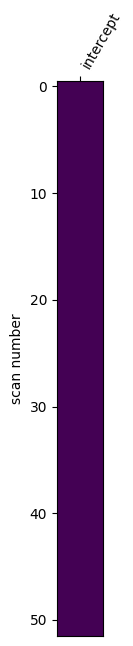

In [3]:
design_matrix = make_second_level_design_matrix(subjs_list_typ)

plot_design_matrix(design_matrix)

In [16]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['HighReward_SimPeer_V_HighReward_DisPeer', 
           'HighReward_SimPeer_V_HighReward_Computer',
           'HighReward_SimPeer-fb_V_HighReward_DisPeer-fb', 
           'HighReward_SimPeer-fb_V_HighReward_Computer-fb',
           'HighReward_V_LowReward-fb']
group = 'not_asd'
tasks = ['SR']
alpha = 0.05
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list_typ.copy()
        temp_file_list = []
        for subj in subjs_list_typ:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating group '+contrast+' contrast for '+str(len(temp_file_list))+' subjects')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
        z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
        #z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
        #                           'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
        threshold_data[group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold
        

Calculating group HighReward_SimPeer_V_HighReward_DisPeer contrast for 49 subjects
Calculating group HighReward_SimPeer_V_HighReward_Computer contrast for 49 subjects
Calculating group HighReward_SimPeer-fb_V_HighReward_DisPeer-fb contrast for 49 subjects


/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/glm/thresholding.py:297: UserWarning: The given float value must not exceed 3.8367711718463022. But, you have given threshold=inf.
  stat_img = threshold_img(


Calculating group HighReward_SimPeer-fb_V_HighReward_Computer-fb contrast for 49 subjects
Calculating group HighReward_V_LowReward-fb contrast for 49 subjects


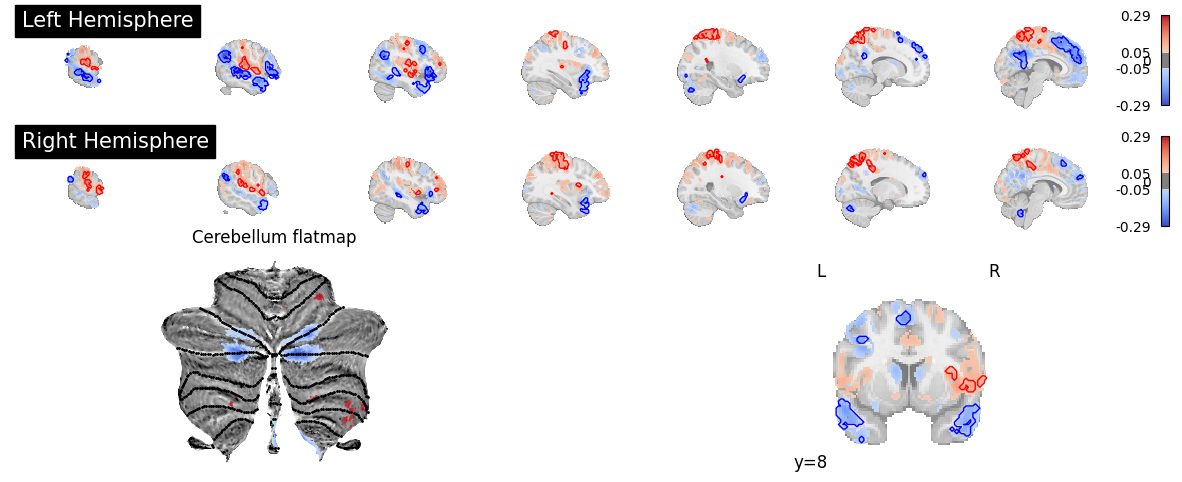

In [3]:
filename = data_dir+'/group/'+'not_asd_SR_HighReward_V_LowReward-fb'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

### Similar Peer vs Computer

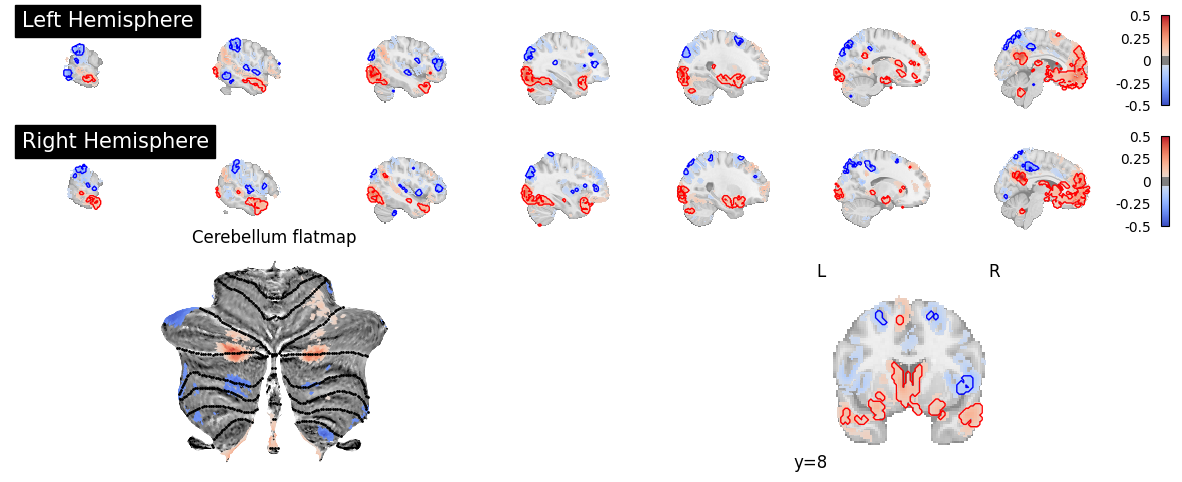

In [4]:
filename = data_dir+'/group/'+'not_asd_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

### Similar Peer vs Dissimilar Peer

inf


/export/software/neuron/new_conda/envs/py310/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:420: UserWarning: empty mask
  xmin_, xmax_, ymin_, ymax_, zmin_, zmax_ = get_mask_bounds(


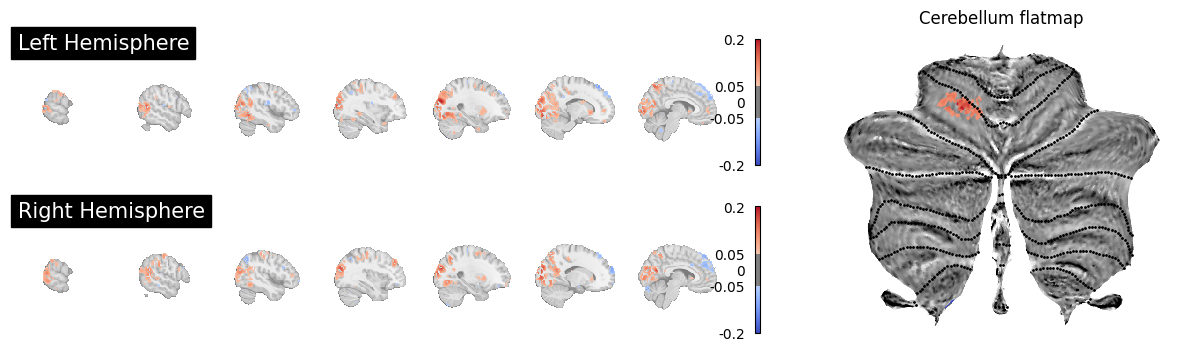

In [13]:
filename = data_dir+'/group/'+'not_asd_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb'

plot_transparent_threshold(filename, thresh=0.05)

## Autistic Adolescents

In [26]:
design_matrix = make_second_level_design_matrix(subjs_list_asd)


mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['HighReward_SimPeer-fb_V_HighReward_DisPeer-fb', 
           'HighReward_SimPeer-fb_V_HighReward_Computer-fb']
group = 'asd'
tasks = ['SR']
alpha = 0.05
mc = 'fdr'


#threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        
        temp_file_list = []
        for subj in subjs_list_asd:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii'))
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating '+' group '+contrast+' contrast')
        
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        z_map = model.compute_contrast(output_type='z_score')

        z_map.to_filename(os.path.join(data_dir,'group',
                                   'zmap_'+group+'_'+task+'_'+contrast+'_unc.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                   'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'.nii.gz'))
        #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
        z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                   'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'.nii.gz'))
        #z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
        #                           'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
        threshold_data['zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)] = threshold
        

Calculating  group HighReward_SimPeer-fb_V_HighReward_DisPeer-fb contrast


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 3.3860459710725954. But, you have given threshold=inf.
  f"The given float value must not exceed {value_check}. "


Calculating  group HighReward_SimPeer-fb_V_HighReward_Computer-fb contrast


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 4.487811038126179. But, you have given threshold=inf.
  f"The given float value must not exceed {value_check}. "


In [28]:
threshold_data

{'zmap_not_asd_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb_fdr-0.05': inf,
 'zmap_not_asd_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb_fdr-0.05': 2.7643320832064866,
 'zmap_asd_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb_fdr-0.05': inf,
 'zmap_asd_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb_fdr-0.05': inf}

### Similar Peer vs Computer Feedback

inf


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:434: UserWarning: empty mask
  new_img_like(img, not_mask, affine)
/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


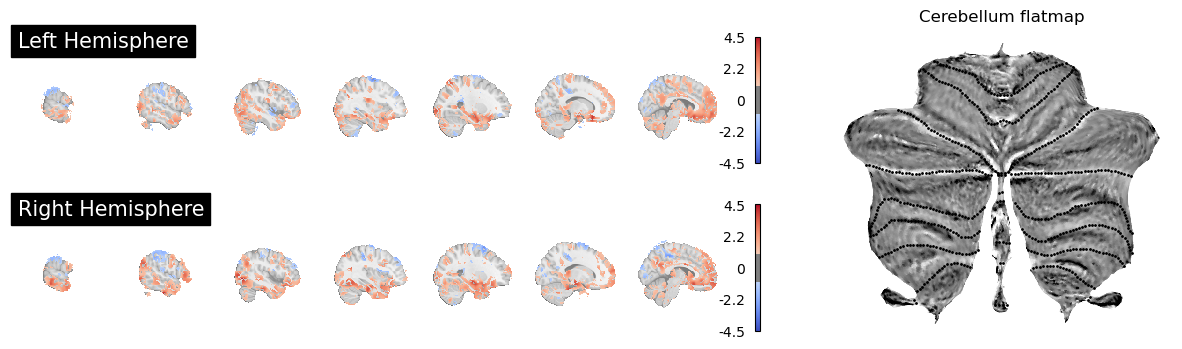

In [29]:
filename = 'zmap_asd_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb'

plot_stat_contours(filename)

### Similar Peer vs Dissimilar Peer Feedback

inf


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:434: UserWarning: empty mask
  new_img_like(img, not_mask, affine)
/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


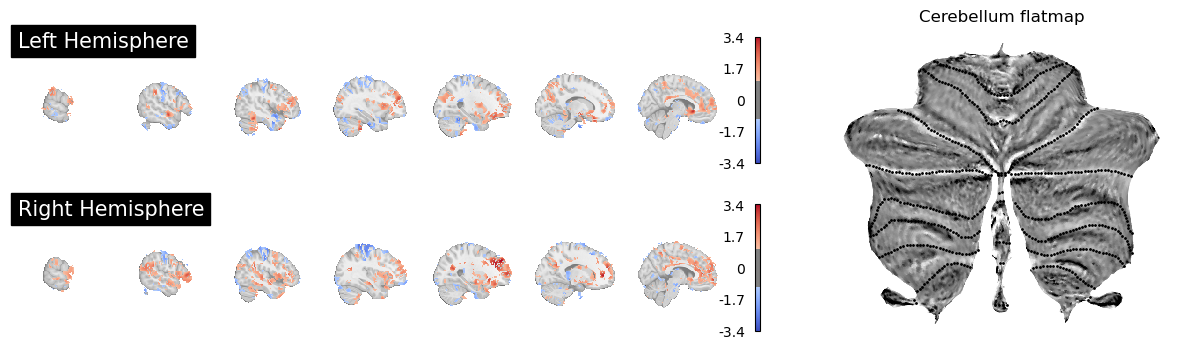

In [30]:
filename = 'zmap_asd_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb'

plot_stat_contours(filename)

# All Subjects

<AxesSubplot:label='conditions', ylabel='scan number'>

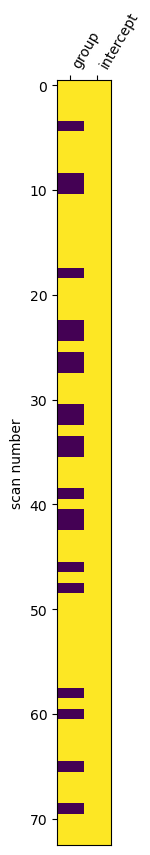

In [31]:
subjs_info_num = subjs_info.copy()
subjs_info_num = subjs_info_num.replace({'group': {'asd': -1, 'not_asd': 1}})
subjs_info_num = subjs_info_num.rename({'participant_id': 'subject_label'}, axis='columns')

design_matrix = make_second_level_design_matrix(subjs_list, subjs_info_num)

plot_design_matrix(design_matrix)

In [33]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['HighReward_SimPeer-fb_V_HighReward_DisPeer-fb', 
           'HighReward_SimPeer-fb_V_HighReward_Computer-fb']
contrasts_2nd = ['intercept','group']
tasks = ['SR']
group = 'all'
alpha = 0.05
mc='fdr'
          


#threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        
        temp_file_list = []
        for subj in subjs_list:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii'))
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating '+' group '+contrast+' contrast')
        
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        for contrast_2nd in contrasts_2nd:
            z_map = model.compute_contrast(contrast_2nd, output_type='z_score')

            z_map.to_filename(os.path.join(data_dir,'group',
                                       'zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_unc.nii.gz'))
            
            # Multiple Comparisons Correction
            z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
            z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                       'zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_'+mc+'-'+str(alpha)+'.nii.gz'))
            #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
            z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                       'zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_'+mc+'-'+str(alpha)+'.nii.gz'))
            #z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
            #                           'zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
            threshold_data['zmap_'+group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_'+mc+'-'+str(alpha)] = threshold

Calculating  group HighReward_SimPeer-fb_V_HighReward_DisPeer-fb contrast


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 3.524085793328186. But, you have given threshold=inf.
  f"The given float value must not exceed {value_check}. "
/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 3.966734358287802. But, you have given threshold=inf.
  f"The given float value must not exceed {value_check}. "


Calculating  group HighReward_SimPeer-fb_V_HighReward_Computer-fb contrast


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/_utils/param_validation.py:73: UserWarning: The given float value must not exceed 3.7031582775136473. But, you have given threshold=inf.
  f"The given float value must not exceed {value_check}. "


2.6704648281622547


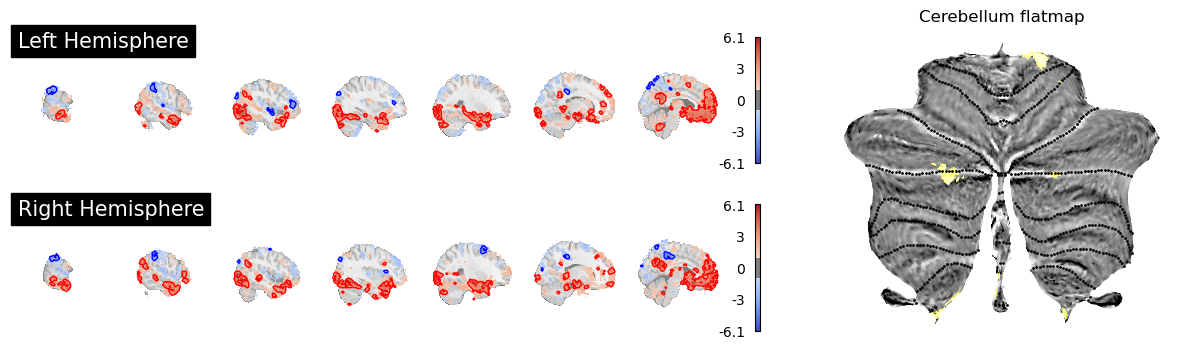

In [34]:
filename = 'zmap_all_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb_intercept'

plot_stat_contours(filename)

inf


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:434: UserWarning: empty mask
  new_img_like(img, not_mask, affine)
/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


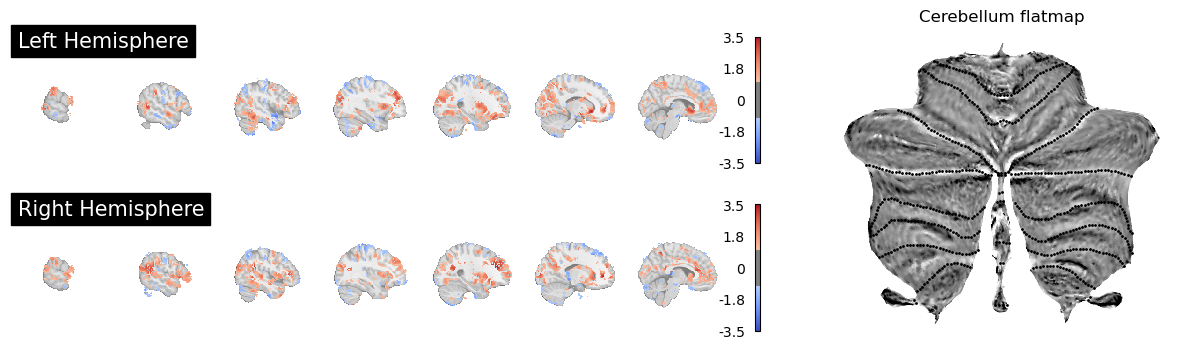

In [35]:
filename = 'zmap_all_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb_intercept'

plot_stat_contours(filename)

## Group differences 
Where non-autistic > autistic

### Similar Peer vs Computer

inf


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:434: UserWarning: empty mask
  new_img_like(img, not_mask, affine)
/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


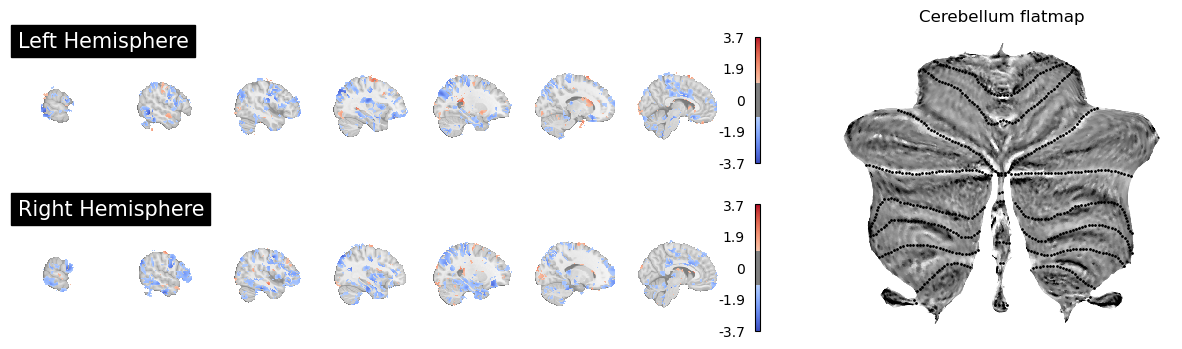

In [36]:
filename = 'zmap_all_SR_HighReward_SimPeer-fb_V_HighReward_Computer-fb_group'

plot_stat_contours(filename)

### Similar Peer vs Dissimilar Peer

inf


/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_slicers.py:434: UserWarning: empty mask
  new_img_like(img, not_mask, affine)
/export/software/neuron/new_conda/envs/py37/lib/python3.7/site-packages/nilearn/plotting/displays/_axes.py:75: UserWarning: No contour levels were found within the data range.
  data_2d.copy(), extent=(xmin, xmax, zmin, zmax), **kwargs


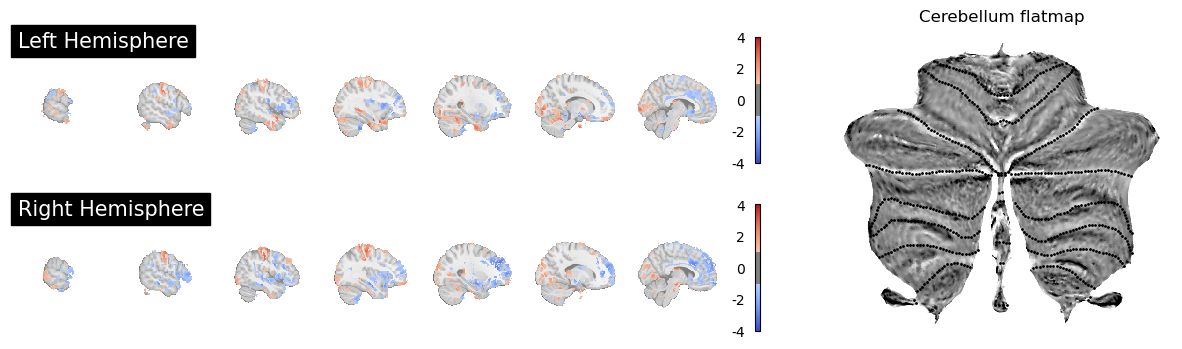

In [37]:
filename = 'zmap_all_SR_HighReward_SimPeer-fb_V_HighReward_DisPeer-fb_group'

plot_stat_contours(filename)